**Importar Librerías**

In [12]:
import pandas as pd
from pandas import datetime
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential    
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

from sklearn.metrics import mean_squared_error   # para calcular el error cuadratico medio
from math import sqrt

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

**Preprocesing Data - Functions:**
1. Drop outliers.
2. Standardizing values.
3. Dealing with missing values. 
4. Feature Engineering - Differencing.
5. Feature Engineering - Computing Time Features.

In [13]:
#Remove Outliers:
def remove_outliers(dataframe):
  data = dataframe.copy()
  data.drop(columns=['Latitud', 'Longitud', 'Fecha', 'Ruido (dB)', 'UV', 'Presion (hPa)'], inplace=True)
  for (columnName, columnData) in data.iteritems():
      feature = data[columnName]
      #Search for outliers:
      outliers = feature.between(feature.quantile(.25), feature.quantile(.75))
      index_names = data[~outliers].index
      #Replace outliers with word "NaN":
      data[columnName].loc[index_names] = np.nan
      #print(outliers.value_counts())
      #print(index_names)
  return data

In [14]:
#Computing Standard Vector.
from sklearn.preprocessing import StandardScaler
def standarized_vector(dataframe):
  data = dataframe.copy()
  data.drop(columns=['Latitud', 'Longitud', 'Fecha'], inplace=True)
  vector_scaler = StandardScaler()
  vector_scaler.fit_transform(data)
  return vector_scaler

In [15]:
#Standarizing Values.
def standarized_values(dataframe, vector_scaler):
  data = dataframe.copy()
  data.drop(columns=['Latitud', 'Longitud', 'Fecha'], inplace=True)
  df_standard_scale = pd.DataFrame(vector_scaler.transform(data))
  df_standard_scale = df_standard_scale.rename(columns={0: "CO (ug/m3)", 1: "H2S (ug/m3)", 2: "NO2 (ug/m3)", 3: "O3 (ug/m3)", 4: "PM10 (ug/m3)", 5: "PM2.5 (ug/m3)", 6: "SO2 (ug/m3)", 7: "Ruido (dB)", 8: "UV", 9: "Humedad (%)", 10: "Presion (hPa)", 11: "Temperatura (C)"})
  return df_standard_scale

In [16]:
#Interpolation of missing values:
def deal_missing_values(dataframe):
  data = dataframe.copy()
  for (columnName, columnData) in data.iteritems():
    feature = data[columnName]
    data[columnName] = feature.interpolate()
  return data

In [17]:
#Time differencing (t-1):
def differencing_transform(dataframe):
  data = dataframe.copy()
  for (columnName, columnData) in data.iteritems():
    #data_log = np.log(data[columnName])
    data_dif_time = data[columnName]
    data[columnName] = data_dif_time - data_dif_time.shift(1)
  return data

In [18]:
# Generate multivariate features from n_steps of a group of parallel secuences.
def generate_time_features(dataframe, n_steps_in, n_steps_out):
  x, y = [], []
  for i in range(len(dataframe.index)):
      end_step = i + n_steps_in
      out_end_ix = end_step + n_steps_out
      if out_end_ix > len(dataframe.index)-1:
        break
      # Separate time feature values from time target values.
      x.append(dataframe.iloc[i:end_step, :].values)
      # Get only pollutants for target.
      y.append(dataframe.iloc[end_step:out_end_ix, 0:6].values)
  return np.array(x), np.array(y)

In [19]:
# Split Train/Test dataset:
def split_train_test(x_time_features, y_time_targets):
  X_train, X_test, y_train, y_test = train_test_split(x_time_features, y_time_targets, test_size=0.15, random_state=42, shuffle=True)
  return X_train, X_test, y_train, y_test

In [88]:
# Generate multivariate features from n_steps with the first next hour for persistent model.
def generate_persistent_features(dataframe, n_steps_in, n_steps_out):
  x, y = [], []
  for i in range(len(dataframe.index)):
      end_step = i + n_steps_in
      out_end_ix = end_step + n_steps_out
      if out_end_ix > len(dataframe.index)-1:
        break
      # Separate time feature values from time target values.
      x.append(dataframe.iloc[i:end_step, :].values)
      # Get only the next hour pollutants for target.
      next_hour = np.zeros((n_steps_out, 6))
      next_hour[:,:] = dataframe.iloc[end_step, 0:6].values
      y.append(next_hour)
      
  return np.array(x), np.array(y)

In [93]:
# Generate multivariate features from n_steps with the first next hour for persistent model from y_test.
def generate_persistent_features_test(y_test, n_steps_out):
  y_persistent_test = []
  for i in range(y_test.shape[0]):
    next_hour = np.zeros((n_steps_out, 6))
    next_hour[:,:] = y_test[i][0]
    y_persistent_test.append(next_hour)

  return np.array(y_persistent_test)

In [20]:
def plot_features(dataset):
  for (columnName, columnData) in dataset.iteritems():
    plt.figure()
    print(columnName)
    dataset[columnName].plot(figsize=(10,10),grid =True)
    plt.show()

CO (ug/m3)


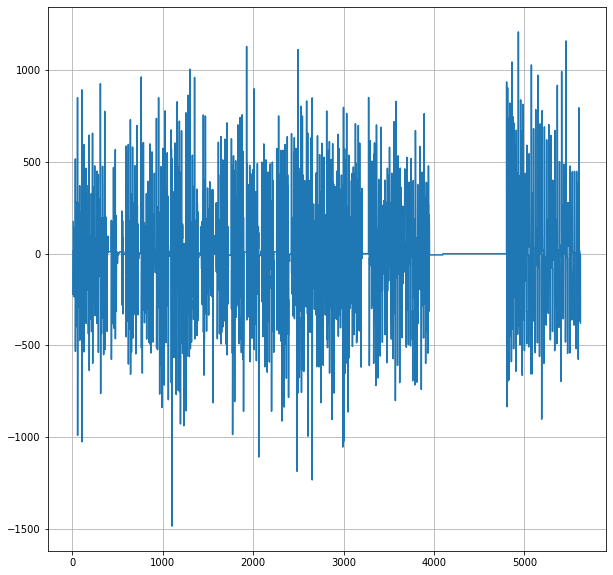

H2S (ug/m3)


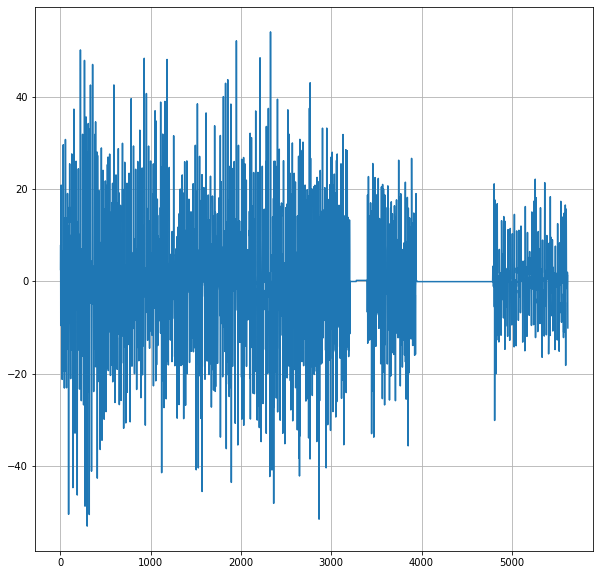

NO2 (ug/m3)


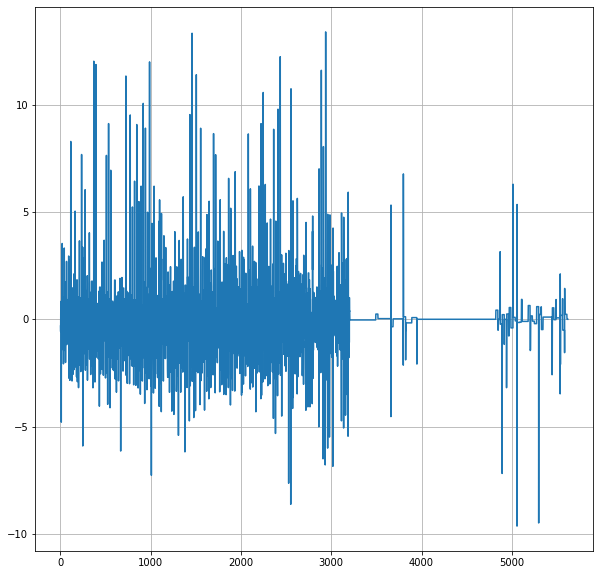

O3 (ug/m3)


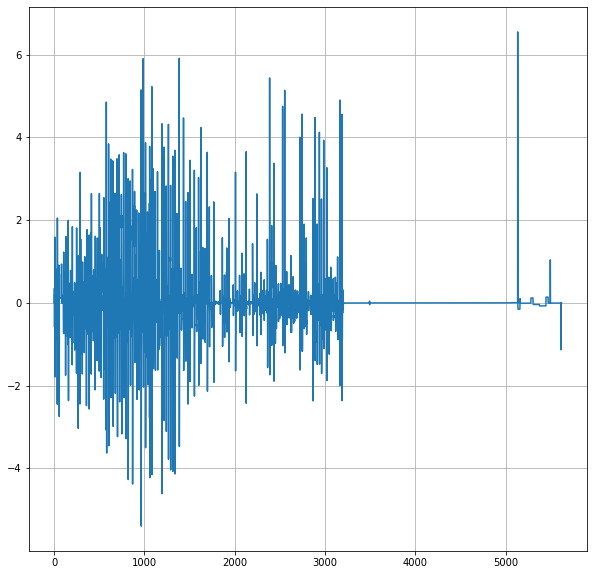

PM10 (ug/m3)


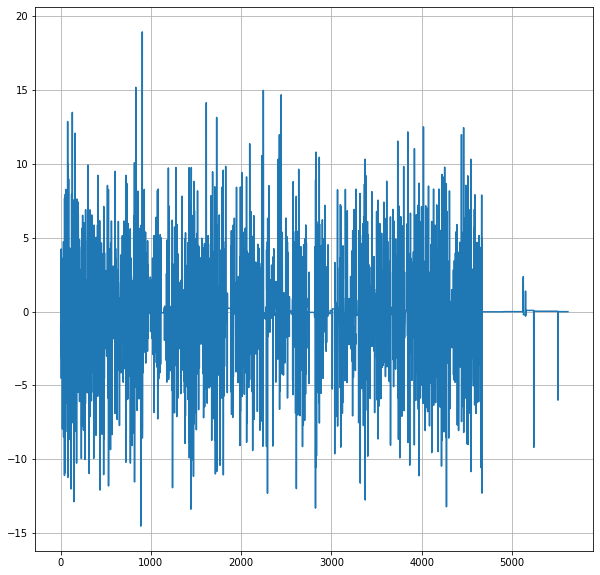

PM2.5 (ug/m3)


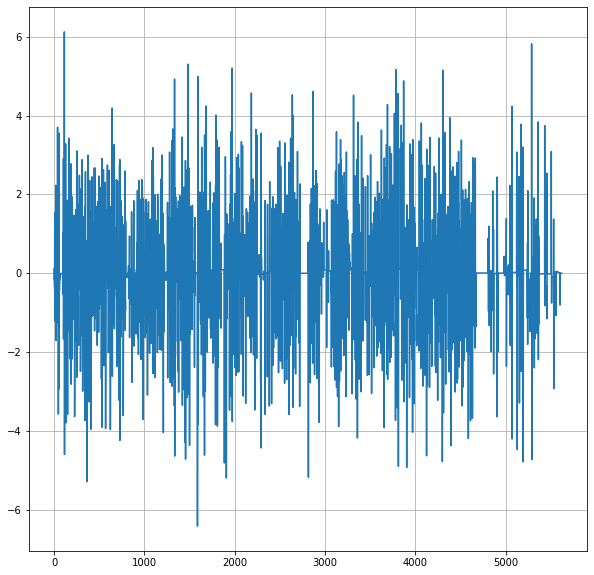

SO2 (ug/m3)


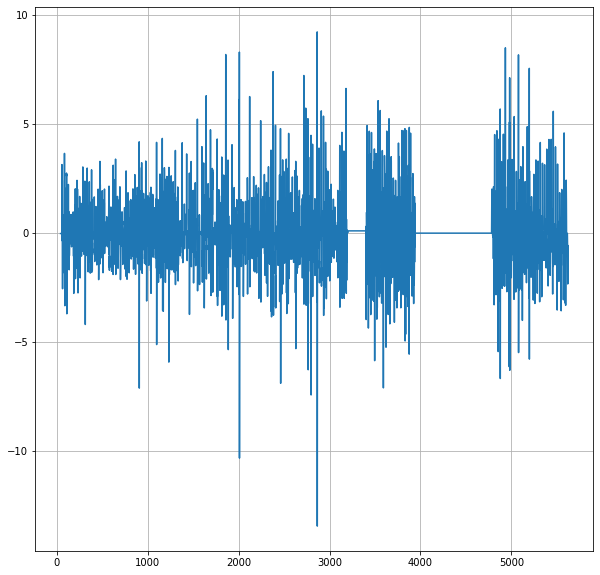

Humedad (%)


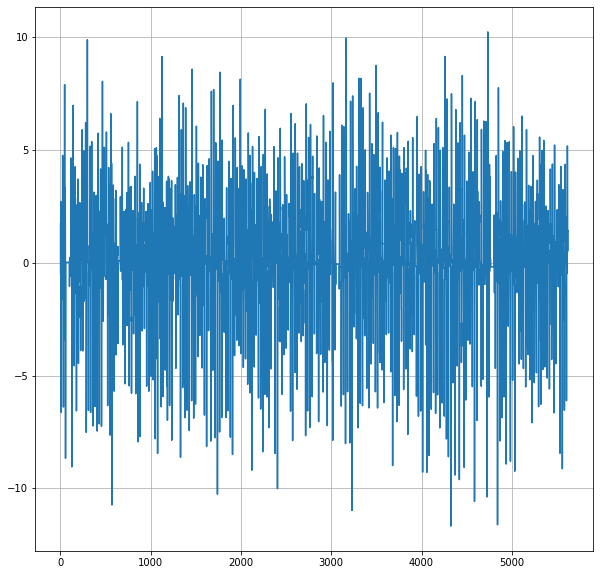

Temperatura (C)


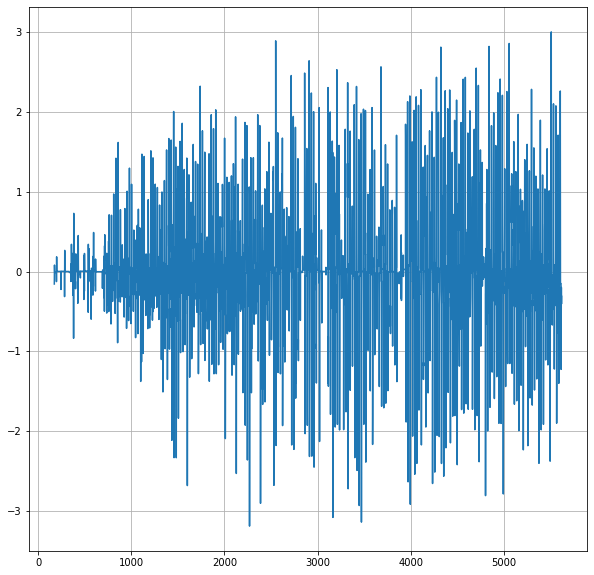

In [21]:
# Generate train time features dataset from all qHAWAX stations.
n_steps_in = 13
n_steps_out = 6
total_time_features = 0
total_time_targets = 0
n_stations = 10
month_from_test = 10

for i in range(n_stations):
  # Change name of file to read.
  station_file_number = str(i+1)
  station_file_name = "qHAWAX-VariablesContaminacion_1 (" + station_file_number + ").csv"
  # Read CSV file.
  dataset = pd.read_csv(station_file_name)
  # Remove outliers.
  data_outliers = remove_outliers(dataset)
  # Deal with missing values.
  data_miss = deal_missing_values(data_outliers)
  # Time Differences.
  dataset_time_diff = differencing_transform(data_miss)

  # Generate Train time features from time windowing process.
  x_time_features, y_time_targets = generate_time_features(dataset_time_diff, n_steps_in, n_steps_out)
  if (i == 0):
    total_time_features = x_time_features
    total_time_targets = y_time_targets
  else:
    total_time_features = np.concatenate((total_time_features, x_time_features), axis=0)
    total_time_targets = np.concatenate((total_time_targets, y_time_targets), axis=0)

# Split Train/Test.
X_train, X_test, y_train, y_test = split_train_test(total_time_features, total_time_targets)
# Stadarizing values.
# data_train_scaled, robust_scaled_vector = robust_scaler(X_train, y_train)

plot_features(dataset_time_diff)

In [22]:
print("Size of time features data array:", total_time_features.shape)
print("Size of time target data array:", total_time_targets.shape)

Size of time features data array: (46115, 13, 9)
Size of time target data array: (46115, 6, 6)


In [23]:
print("Size of time features TRAIN data array:", X_train.shape)
print("Size of time features TEST data array:", X_test.shape)
print("Size of time target TRAIN data array:", y_train.shape)
print("Size of time target TEST data array:", y_test.shape)

Size of time features TRAIN data array: (39197, 13, 9)
Size of time features TEST data array: (6918, 13, 9)
Size of time target TRAIN data array: (39197, 6, 6)
Size of time target TEST data array: (6918, 6, 6)


**Modelo de Persistencia y Cálculo de RMSE**

In [137]:
y_persistent_test = generate_persistent_features_test(y_test, n_steps_out)
y_persistent_test.shape

sum_rmse = 0
rmse_per_variable = []
for row in range(y_test.shape[0]):  # por cada semana predicha
  for col in range(y_test.shape[1]): # por cada dia 
    sum_rmse += (y_test[row][col] - y_persistent_test[row][col])**2

for i in range(len(sum_rmse)):
  rmse_per_variable.append(sqrt(sum_rmse[i] / (y_test.shape[0] * y_test.shape[1])))

rmse_per_variable

[nan, 6.320319901690132, nan, nan, 5.109986460531219, nan]

**NN Architecture:**
- Multi-variate.
- Multiple steps.

In [24]:
x_train = X_train
# Aplana las secuencias de salida
n_output = y_train.shape[1] * y_train.shape[2] # numero de salidas
y_train = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
#Topología de CNN
n_kernel = 3
n_filters = 100
# obtiene el numero de series (tercera adimension de X)
n_features = x_train.shape[2]
# define arquitectura de modelo MLP
modelo = Sequential()
modelo.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_steps_in, n_features)))
modelo.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
modelo.add(MaxPooling1D(pool_size=2))
modelo.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
modelo.add(MaxPooling1D(pool_size=2))    
modelo.add(Flatten())
modelo.add(Dense(100, activation='relu'))
modelo.add(Dense(n_output))
modelo.compile(loss='mse', optimizer='adam')

# entrena el modelo MLP con la la data de entrenamiento generada
modelo.fit(x_train, y_train, epochs=1000, verbose=0)

# muestra un resumen de la topologia del modelo
modelo.summary()

In [138]:
#Pendientes
- Modelo Base de Persistencia. - (OK)
- Función para evaluar desempeño de NN (RMSE) - (OK)
- Normalización Robusta de Parámetros
- ¿Qué hacer con los valores NaN?
- CNN --> Conv2D?

SyntaxError: ignored